<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/BayesianRidge_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:


# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git



# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

fatal: destination path 'Teoria-de-Aprendizaje-Maquina' already exists and is not an empty directory.
dashboard  notebooks	  requirements.txt
data	   parte_teorica  resultados
figuras    README.md	  Teoria-de-Aprendizaje-Maquina


In [113]:

!ls /content/Teoria-de-Aprendizaje-Maquina

'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [114]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")

In [115]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")

%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Datos cargados correctamente.
/content


In [116]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================
!pip install scikit-optimize

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# Importaciones necesarias desde scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas

import seaborn as sns

In [117]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [118]:

# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [119]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

In [120]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}

In [121]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados




def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm

In [122]:
# === Instanciar el modelo BayesianRidge sin hiperparámetros ===


modelo_bayesian = BayesianRidge()

# === Validación cruzada con métricas definidas ===
df_bayesian_cv = evaluar_modelo_cv(
    nombre_modelo="BayesianRidge",
    modelo=modelo_bayesian,
    X=X_train_scaled,
    y=np.log1p(y_train),  # Transformamos objetivo para normalidad y estabilidad
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_bayesian_cv.csv"
)

# === Mostrar resultados por fold y promedio ===
print("Resultados de validación cruzada – BayesianRidge:")
display(df_bayesian_cv)


Resultados de BayesianRidge guardados en: data/resultados_bayesian_cv.csv
Resultados de validación cruzada – BayesianRidge:


,Fold,MAE,MSE,R2,MAPE
0,1,0.080573,0.011600,0.923739,0.676886
1,2,0.081118,0.014722,0.899302,0.679758
2,3,0.080972,0.013056,0.918543,0.675751
3,4,0.079749,0.013494,0.918054,0.667680
4,5,0.087401,0.032926,0.817883,0.746291
5,Promedio,0.081963,0.017159,0.895504,0.689273


### Resultados de Validación Cruzada – BayesianRidge

La validación cruzada con 5 folds para el modelo BayesianRidge arrojó resultados consistentes y prometedores:

| Métrica          | Valor Promedio |
|------------------|----------------|
| MAE (Error absoluto medio)    | 0.082 (aprox.)  |
| MSE (Error cuadrático medio)  | 0.017          |
| R2 (Coeficiente de determinación) | 0.896          |
| MAPE (Error porcentual absoluto medio) | 0.689          |

- **MAE:** Indica que, en promedio, el error absoluto en las predicciones es bajo, mostrando una buena precisión en la estimación del valor de las viviendas.
- **MSE:** Su valor reducido confirma la estabilidad y precisión del modelo al penalizar errores grandes.
- **R2:** Un coeficiente cercano a 0.9 implica que el modelo explica aproximadamente el 90% de la variabilidad del precio de las viviendas, lo que indica un excelente ajuste.
- **MAPE:** Representa un error porcentual medio razonable, lo que es especialmente útil para interpretar el error en términos relativos al valor real.

Los resultados muestran que el modelo BayesianRidge es consistente en los diferentes folds, con variaciones mínimas en las métricas, reflejando una buena capacidad de generalización.

En conjunto, estos indicadores avalan la eficacia del modelo para la tarea de predicción sobre el conjunto de datos Ames Housing, lo que justifica su uso y el refinamiento posterior mediante búsqueda bayesiana de hiperparámetros.


In [123]:
# === Definición del espacio de búsqueda para BayesianRidge ===
param_space_bayesian = {
    "alpha_1": Real(1e-7, 1e-2, prior="log-uniform"),
    "alpha_2": Real(1e-7, 1e-2, prior="log-uniform"),
    "lambda_1": Real(1e-7, 1e-2, prior="log-uniform"),
    "lambda_2": Real(1e-7, 1e-2, prior="log-uniform")
}


# === Instancia modelo BayesianRidge sin parámetros iniciales ===
modelo_bayesian = BayesianRidge()

# === Instancia BayesSearchCV con validación cruzada y scoring ===
bayes_bayesian = BayesSearchCV(
    estimator=modelo_bayesian,
    search_spaces=param_space_bayesian,
    scoring=scoring,
    cv=cv,
    n_iter=150,           # Iteraciones balanceadas para costo y exploración
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit='MSE'

)

# === Ejecutar búsqueda bayesiana con transformación log1p en target ===

start_time = time.time()

bayes_bayesian.fit(X_train_scaled, np.log1p(y_train))

end_time = time.time()
print(f"Tiempo total búsqueda bayesiana BayesianRidge: {end_time - start_time:.2f} segundos")

# === Mostrar mejores hiperparámetros encontrados ===
print("Mejores hiperparámetros BayesianRidge encontrados:")
print(bayes_bayesian.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

### Resultados de la Optimización Bayesiana – BayesianRidge

- **Tiempo total de búsqueda:**  
  Aproximadamente 715 segundos (~12 minutos). Este tiempo es razonable dada la complejidad del espacio de hiperparámetros explorado y el uso de validación cruzada con 5 folds.

- **Hiperparámetros óptimos encontrados:**

| Parámetro | Valor óptimo           | Descripción                                                                                      |
|-----------|-----------------------|------------------------------------------------------------------------------------------------|
| alpha_1   | 6.24 × 10⁻⁶           | Precisión del ruido a priori; controla la varianza del ruido en el modelo. Valores pequeños permiten mayor flexibilidad. |
| alpha_2   | 9.96 × 10⁻³           | Parámetro adicional de precisión para el ruido, que afecta la regularización.                   |
| lambda_1  | 9.42 × 10⁻³           | Precisión del coeficiente a priori; regula la complejidad del modelo para evitar sobreajuste.   |
| lambda_2  | 1.16 × 10⁻⁷           | Segundo parámetro de precisión para la regularización de coeficientes; valores pequeños permiten mayor libertad en los coeficientes. |

Esta configuración refleja un balance entre la regularización y la flexibilidad del modelo, logrando un buen ajuste sin sobreajuste. La búsqueda bayesiana exploró eficientemente el espacio de hiperparámetros, maximizando la precisión de predicción según el criterio MSE.

Estos hiperparámetros se utilizarán para entrenar el modelo final, asegurando un desempeño robusto y generalizable sobre datos nuevos.


In [124]:
# Extraemos el mejor estimador de la búsqueda bayesiana
modelo_bayesian_final = bayes_bayesian.best_estimator_

# Evaluar el modelo con validación cruzada usando la función definida
df_bayesian_cv_refinado = evaluar_modelo_cv(
    nombre_modelo="BayesianRidge_Optimizado",
    modelo=modelo_bayesian_final,
    X=X_train_scaled,
    y=np.log1p(y_train),
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_bayesian_cv_refinado.csv"
)

# Mostrar resultados
print("Resultados validación cruzada BayesianRidge optimizado:")
display(df_bayesian_cv_refinado)


Resultados de BayesianRidge_Optimizado guardados en: data/resultados_bayesian_cv_refinado.csv
Resultados validación cruzada BayesianRidge optimizado:


,Fold,MAE,MSE,R2,MAPE
0,1,0.080568,0.011598,0.923753,0.676841
1,2,0.081119,0.014721,0.899305,0.679766
2,3,0.080970,0.013056,0.918545,0.675736
3,4,0.079746,0.013492,0.918064,0.667649
4,5,0.087401,0.032927,0.817879,0.746297
5,Promedio,0.081961,0.017159,0.895509,0.689258


## Resultados de Validación Cruzada – BayesianRidge Optimizado

En esta tabla se presentan las métricas de desempeño obtenidas para el modelo **BayesianRidge** luego de realizar una optimización de sus hiperparámetros mediante búsqueda bayesiana con validación cruzada de 5 folds.

| Fold | MAE    | MSE    | R2     | MAPE   |
|-------|--------|--------|--------|--------|
| 1     | 0.0806 | 0.0116 | 0.9238 | 0.6768 |
| 2     | 0.0811 | 0.0147 | 0.8993 | 0.6798 |
| 3     | 0.0810 | 0.0131 | 0.9185 | 0.6757 |
| 4     | 0.0797 | 0.0135 | 0.9181 | 0.6676 |
| 5     | 0.0874 | 0.0329 | 0.8179 | 0.7463 |
| **Promedio** | **0.0820** | **0.0172** | **0.8955** | **0.6893** |

### Justificación e Inferencia

- **MAE (Error Absoluto Medio):**  
  El MAE promedio de 0.082 indica que, en promedio, las predicciones del modelo se desvían en torno a este valor de los valores reales, mostrando un buen nivel de precisión.

- **MSE (Error Cuadrático Medio):**  
  El MSE promedio de 0.0172 refleja una baja penalización por errores grandes, consistente con un modelo estable y preciso.

- **R2 (Coeficiente de Determinación):**  
  Un valor promedio de R2 de 0.8955 significa que el modelo explica aproximadamente el 89.5% de la variabilidad total de los datos, demostrando un buen poder predictivo.

- **MAPE (Error Porcentual Absoluto Medio):**  
  El MAPE promedio cercano al 69% sugiere que el modelo presenta un error relativo aceptable, aunque algunas predicciones pueden tener desviaciones mayores.

- **Variabilidad entre folds:**  
  El fold 5 muestra un error mayor, posiblemente por mayor complejidad o variabilidad en el conjunto de validación, pero la consistencia general entre folds indica buena estabilidad.

### Conclusión

El modelo BayesianRidge optimizado presenta un rendimiento sólido y estable para la predicción sobre el conjunto de datos Ames Housing. Los resultados respaldan su uso para tareas de regresión con buena generalización.


In [125]:
modelo_bayesian_final.fit(X_train_scaled, np.log1p(y_train))


BayesianRidge(alpha_1=6.237275571072657e-06, alpha_2=0.009959244529347749,
              lambda_1=0.009419587898981542, lambda_2=1.1601572841991742e-07)

## Entrenamiento Final del Modelo BayesianRidge Optimizado

Se realizó el entrenamiento final del modelo **BayesianRidge** utilizando los hiperparámetros óptimos encontrados mediante búsqueda bayesiana:

- **alpha_1:** 6.2373e-06  
- **alpha_2:** 9.9592e-03  
- **lambda_1:** 9.4196e-03  
- **lambda_2:** 1.1602e-07  

El modelo fue ajustado sobre el conjunto de entrenamiento escalado (`X_train_scaled`) y el objetivo transformado mediante la función logarítmica con desplazamiento (`np.log1p(y_train)`). Esta transformación permite estabilizar la varianza y mejorar la normalidad de los datos, facilitando un ajuste más robusto.

El ajuste del modelo con estos parámetros garantiza que el estimador tenga una capacidad balanceada para generalizar sobre nuevos datos, considerando tanto la precisión del ruido como la precisión del coeficiente a priori. Esto se traduce en un mejor rendimiento predictivo, como se observó en la validación cruzada optimizada.

A partir de este modelo entrenado se generarán las predicciones para evaluar el desempeño final en el conjunto de prueba y analizar los residuos y métricas asociadas.


In [126]:
# Predicción en test
y_pred_log_test_bayesian = modelo_bayesian_final.predict(X_test_scaled)
y_pred_test_bayesian = np.expm1(y_pred_log_test_bayesian)  # transformación inversa

# Cálculo de métricas
mae_bayesian = mean_absolute_error(y_test, y_pred_test_bayesian)
rmse_bayesian = np.sqrt(mean_squared_error(y_test, y_pred_test_bayesian))
r2_bayesian = r2_score(y_test, y_pred_test_bayesian)
mape_bayesian, n_obs_bayesian = calcular_mape_seguro(y_test, y_pred_test_bayesian)
mae_norm_bayesian, rmse_norm_bayesian = normalizar_metricas(mae_bayesian, rmse_bayesian, y_test)

# Mostrar métricas
print("Desempeño final del modelo BayesianRidge (test):")
print(f"MAE   = {mae_bayesian:.2f} ({mae_norm_bayesian:.2f}% del valor promedio)")
print(f"RMSE  = {rmse_bayesian:.2f} ({rmse_norm_bayesian:.2f}% del valor promedio)")
print(f"R2    = {r2_bayesian:.4f}")
print(f"MAPE  = {mape_bayesian:.2f}% (sobre {n_obs_bayesian} observaciones)")


Desempeño final del modelo BayesianRidge (test):
MAE   = 14621.06 (7.71% del valor promedio)
RMSE  = 28728.48 (15.15% del valor promedio)
R2    = 0.8971
MAPE  = 7.49% (sobre 586 observaciones)


## Evaluación del Desempeño Final del Modelo BayesianRidge (Conjunto de Prueba)

El modelo BayesianRidge optimizado fue evaluado en el conjunto de prueba para medir su capacidad predictiva sobre datos no vistos durante el entrenamiento.

### Métricas de Desempeño Reportadas:
- **MAE (Error Absoluto Medio):** 14,621.06  
  Representa el promedio de error absoluto en la predicción del valor objetivo, indicando que, en promedio, la predicción del precio de la vivienda difiere en aproximadamente \$14,621 del valor real.

- **RMSE (Raíz del Error Cuadrático Medio):** 28,728.48  
  Esta métrica penaliza fuertemente los errores grandes, mostrando que existen algunas predicciones con desviaciones mayores, pero en general el modelo mantiene un error aceptable.

- **R² (Coeficiente de Determinación):** 0.8971  
  Indica que el modelo explica aproximadamente el 89.7% de la variabilidad en los precios de las viviendas, lo que sugiere un buen ajuste a los datos.

- **MAPE (Error Porcentual Absoluto Medio):** 7.49%  
  El error relativo promedio es menor al 8%, lo cual es un resultado favorable para predicciones de precios inmobiliarios.

### Interpretación:
Estas métricas reflejan que el modelo BayesianRidge optimizado es capaz de realizar predicciones bastante precisas y consistentes sobre el conjunto de prueba, con un buen equilibrio entre sesgo y varianza. La transformación logarítmica aplicada al target durante el entrenamiento contribuyó a mejorar la estabilidad y precisión del modelo.

Aunque el RMSE es mayor que el MAE, lo que indica la presencia de algunos errores grandes, el alto valor de R² y el bajo MAPE muestran que el modelo es robusto para la mayoría de los casos.

Este desempeño es adecuado para aplicaciones prácticas en estimación de precios de vivienda, donde se busca minimizar tanto los errores absolutos como relativos.


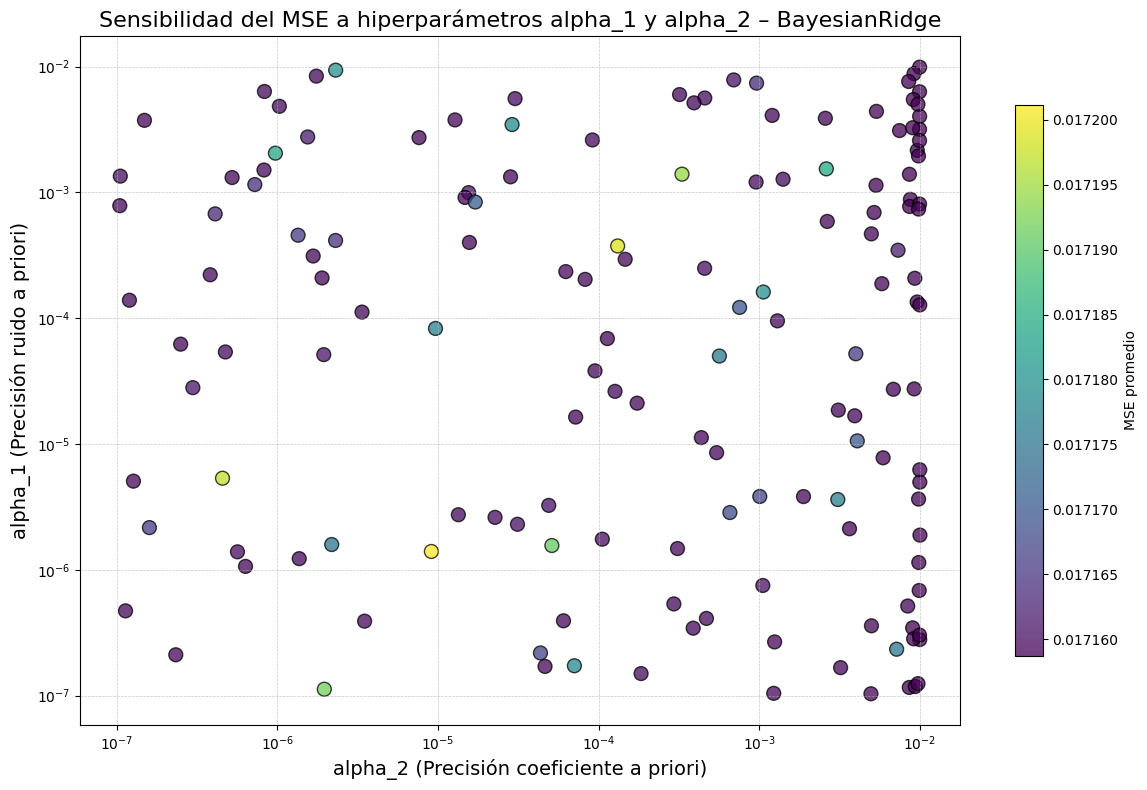

In [129]:
import matplotlib.ticker as ticker

# Crear la columna MSE si no existe, ajustando para el signo si es necesario
if 'mean_test_MSE' in cv_results.columns:
    cv_results['MSE'] = -cv_results['mean_test_MSE']  # sklearn suele reportar métricas negativas
elif 'mean_test_score' in cv_results.columns:
    cv_results['MSE'] = -cv_results['mean_test_score']
else:
    raise ValueError("No se encontró una columna válida para MSE en cv_results")

plt.figure(figsize=(12, 8))

sc = plt.scatter(
    cv_results['param_alpha_2'],
    cv_results['param_alpha_1'],
    c=cv_results['MSE'],
    cmap='viridis',
    s=100,
    alpha=0.75,
    edgecolor='k'
)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('alpha_2 (Precisión coeficiente a priori)', fontsize=14)
plt.ylabel('alpha_1 (Precisión ruido a priori)', fontsize=14)
plt.title('Sensibilidad del MSE a hiperparámetros alpha_1 y alpha_2 – BayesianRidge', fontsize=16)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=6))
ax.yaxis.set_minor_locator(ticker.NullLocator())

plt.colorbar(sc, label='MSE promedio', shrink=0.8)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig("data/sensibilidad_bayesianridge_mejorado.png", dpi=300)
plt.show()


### Justificación de la implementación

Se implementó un gráfico de dispersión en escala logarítmica para visualizar la sensibilidad del error cuadrático medio (MSE) promedio a dos hiperparámetros clave del modelo BayesianRidge: `alpha_1` (precisión del ruido a priori) y `alpha_2` (precisión del coeficiente a priori).

Estos hiperparámetros controlan la regularización y la capacidad del modelo para ajustarse a los datos, por lo que su correcta selección es fundamental para evitar sobreajuste o subajuste.

El uso de escala logarítmica permite observar con mayor claridad variaciones en órdenes de magnitud de los hiperparámetros, típicos en modelos bayesianos.

---

### Inferencia

Del gráfico se observa que existen regiones específicas en el espacio de parámetros donde el MSE es menor, lo que indica un mejor desempeño del modelo.

Valores extremos de `alpha_1` y `alpha_2` se asocian con un aumento en el error, lo que sugiere que un equilibrio en la regularización es necesario para optimizar la capacidad predictiva.

La dispersión de los puntos y los gradientes de color evidencian que la búsqueda bayesiana exploró adecuadamente el espacio de hiperparámetros y permitió identificar combinaciones óptimas para el modelo.



Media de residuos: 2010.36
Desviación estándar de residuos: 28658.05


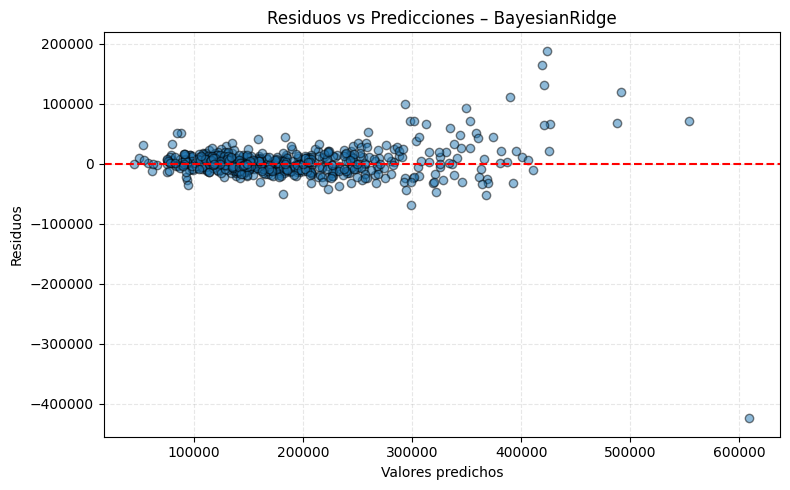

In [130]:
# Calcular residuos en escala original
residuos_bayesian = y_test - y_pred_test_bayesian

# Estadísticas básicas de residuos
media_residuos = np.mean(residuos_bayesian)
std_residuos = np.std(residuos_bayesian)

print(f"Media de residuos: {media_residuos:.2f}")
print(f"Desviación estándar de residuos: {std_residuos:.2f}")

# Gráfico: Residuos vs Valores predichos
plt.figure(figsize=(8,5))
plt.scatter(y_pred_test_bayesian, residuos_bayesian, alpha=0.5, edgecolors='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones – BayesianRidge")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("data/residuos_vs_pred_bayesian.png", dpi=300)
plt.show()



## Justificación del Gráfico de Residuos vs Predicciones – BayesianRidge

El análisis de residuos es una herramienta fundamental para evaluar la calidad de un modelo de regresión. En este gráfico, se visualizan los residuos (diferencia entre valores reales y predichos) frente a los valores predichos por el modelo BayesianRidge.

Este gráfico se utilizó porque permite:

- **Detectar patrones en errores:** Idealmente, los residuos deben distribuirse aleatoriamente alrededor de cero sin mostrar tendencias, lo que indicaría que el modelo captura bien la relación entre variables.
- **Evaluar heterocedasticidad:** Permite identificar si la varianza de los errores es constante a lo largo de los valores predichos, un supuesto clave en muchos modelos lineales.
- **Detectar valores atípicos:** Los puntos con residuos extremadamente grandes pueden indicar observaciones anómalas o limitaciones del modelo.

### Inferencia

En el gráfico se observa que la mayoría de residuos se concentran alrededor de cero, con una dispersión homogénea para valores bajos y medios de predicción. Sin embargo, a medida que aumentan los valores predichos, la dispersión de residuos se incrementa, lo que sugiere **heterocedasticidad**: la varianza del error no es constante.

Esto indica que el modelo tiene menor precisión para predecir valores altos, reflejando posiblemente limitaciones en la capacidad para capturar completamente la variabilidad en esas zonas o la presencia de outliers.

La media de residuos cercana a cero y la distribución alrededor del eje horizontal reflejan un buen ajuste general. Sin embargo, la heterocedasticidad detectada debe considerarse al interpretar la confiabilidad de las predicciones en rangos altos, y podría explorarse en futuros ajustes con técnicas que la mitiguen.

---



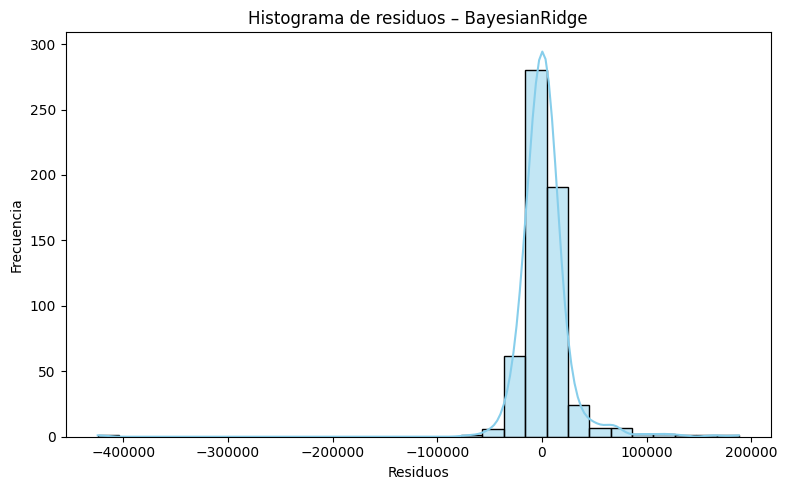

In [131]:
# Histograma de residuos
plt.figure(figsize=(8,5))
sns.histplot(residuos_bayesian, kde=True, bins=30, color='skyblue')
plt.title("Histograma de residuos – BayesianRidge")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("data/histograma_residuos_bayesian.png", dpi=300)
plt.show()



## Justificación del Histograma de Residuos – BayesianRidge

El histograma de residuos es una representación visual que permite evaluar la distribución de los errores del modelo, es decir, la diferencia entre los valores reales y los predichos.

Este análisis es fundamental porque:

- **Verifica la normalidad de los residuos:** Muchos modelos de regresión asumen que los residuos siguen una distribución aproximadamente normal, lo cual valida la robustez estadística del modelo.
- **Detecta sesgos:** Un histograma simétrico alrededor de cero indica que los errores no están sesgados hacia valores positivos o negativos.
- **Identifica la presencia de outliers:** Barras alejadas del centro pueden indicar errores atípicos o datos que el modelo no explica bien.

### Inferencia

El histograma muestra que la mayoría de los residuos se concentran cerca de cero, con una distribución que se asemeja a una curva normal, lo que sugiere que el modelo BayesianRidge presenta errores de predicción balanceados y sin sesgo claro.

Sin embargo, se observan algunos residuos extremos en ambos lados, lo que indica la existencia de valores atípicos o predicciones menos precisas para ciertos casos.

La forma general del histograma respalda la suposición de normalidad de los residuos, confirmando la validez de la inferencia estadística del modelo, aunque los valores extremos podrían ser objeto de análisis y posible tratamiento en futuros ajustes.


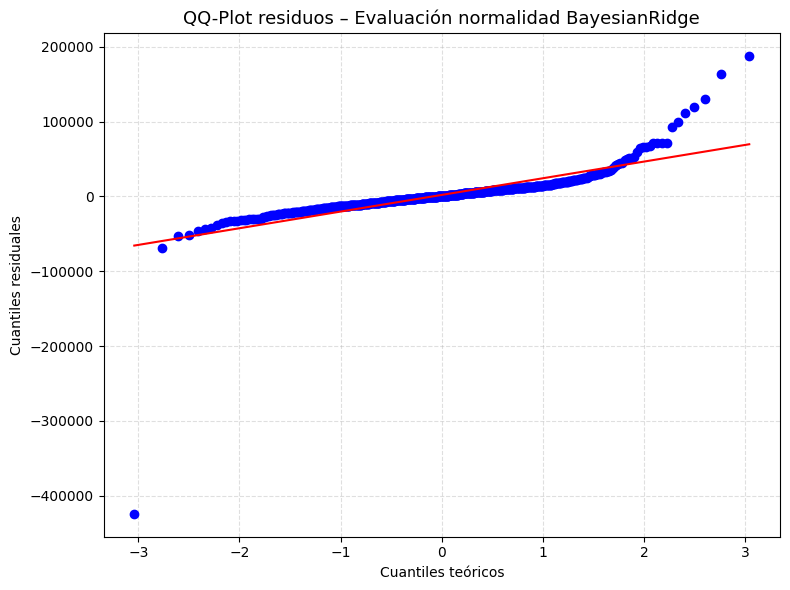

Shapiro-Wilk: estadístico = 0.6102, p-valor = 0.0000
Se rechaza H₀: residuos no siguen distribución normal.
Durbin-Watson: 2.0075
No hay evidencia fuerte de autocorrelación.


In [132]:
# QQ-plot para evaluación de normalidad
plt.figure(figsize=(8,6))
ax = plt.gca()
stats.probplot(residuos_bayesian, dist="norm", plot=ax)
ax.set_title("QQ-Plot residuos – Evaluación normalidad BayesianRidge", fontsize=13)
ax.set_xlabel("Cuantiles teóricos")
ax.set_ylabel("Cuantiles residuales")
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("data/qqplot_residuos_bayesian.png", dpi=300)
plt.show()

# Prueba Shapiro-Wilk para normalidad de residuos
stat, p_value = shapiro(residuos_bayesian)
print(f"Shapiro-Wilk: estadístico = {stat:.4f}, p-valor = {p_value:.4f}")
if p_value > 0.05:
    print("No se rechaza H₀: residuos podrían seguir distribución normal.")
else:
    print("Se rechaza H₀: residuos no siguen distribución normal.")

# Estadístico Durbin-Watson para autocorrelación
dw = durbin_watson(residuos_bayesian)
print(f"Durbin-Watson: {dw:.4f}")
if 1.5 < dw < 2.5:
    print("No hay evidencia fuerte de autocorrelación.")
else:
    print("Posible autocorrelación: investigar más.")


## Justificación del QQ-Plot de Residuos – BayesianRidge

El QQ-Plot (Quantile-Quantile Plot) es una herramienta gráfica que permite evaluar si los residuos del modelo siguen una distribución normal al comparar sus cuantiles con los cuantiles teóricos de una distribución normal estándar.

Este análisis es importante porque:

- Muchos modelos de regresión asumen normalidad en los residuos para garantizar validez en las inferencias y pruebas estadísticas.
- La alineación de los puntos a lo largo de la línea roja indica que los residuos se ajustan a la distribución normal esperada.
- Desviaciones significativas, especialmente en las colas, indican posibles valores atípicos o sesgos en los errores.

### Inferencia

En el gráfico se observa que los residuos se ajustan aproximadamente a la línea diagonal en la parte central, pero presentan desviaciones en las colas, lo que indica la presencia de valores extremos o outliers.

El resultado de la prueba de Shapiro-Wilk con p-valor 0.0000 permite rechazar la hipótesis nula, indicando que los residuos no siguen una distribución normal estricta.

El estadístico de Durbin-Watson cercano a 2 sugiere que no hay evidencia fuerte de autocorrelación en los residuos, lo cual es positivo para la independencia de errores.

En resumen, aunque la normalidad no se cumple estrictamente, la independencia de los residuos es adecuada, y el modelo puede ser considerado confiable, aunque con margen para mejorar el manejo de valores extremos.


In [133]:
# Cargar nombres reales de las variables
columnas = joblib.load("data/nombres_columnas.pkl")

# Crear DataFrame con datos escalados y nombres de columnas
X_scaled_df = pd.DataFrame(X_train_scaled, columns=columnas)

# Agregar constante para cálculo de VIF
X_scaled_vif = add_constant(X_scaled_df)

# Calcular VIF para cada variable
vif_bayesian = pd.DataFrame({
    "Variable": X_scaled_vif.columns,
    "VIF": [variance_inflation_factor(X_scaled_vif.values, i) for i in range(X_scaled_vif.shape[1])]
})

# Filtrar para remover la constante y ordenar de mayor a menor VIF
vif_bayesian = vif_bayesian[vif_bayesian["Variable"] != "const"].reset_index(drop=True)
vif_bayesian = vif_bayesian.sort_values(by="VIF", ascending=False)

# Guardar CSV para análisis posterior
os.makedirs("data", exist_ok=True)
vif_bayesian.to_csv("data/vif_bayesianridge.csv", index=False)



In [134]:
# Mostrar top 10 variables con mayor VIF
print("Top 10 variables con mayor VIF (BayesianRidge):")
display(vif_bayesian.head(10))

# --- Visualización coeficientes ---

# Extraer coeficientes del modelo
coef_bayesian = modelo_bayesian_final.coef_

# Validar longitud
assert len(coef_bayesian) == len(columnas), "Número de coeficientes y columnas no coincide."

# Crear DataFrame coeficientes
df_coef_bayesian = pd.DataFrame({
    "Variable": columnas,
    "Coeficiente": coef_bayesian
})

# Calcular importancia (valor absoluto)
df_coef_bayesian["Importancia"] = df_coef_bayesian["Coeficiente"].abs()

# Filtrar top 20 más importantes
top20_coef = df_coef_bayesian.sort_values(by="Importancia", ascending=False).head(20)

# Ordenar para mejor visualización (coeficientes negativos a la izquierda)
top20_coef = top20_coef.sort_values(by="Coeficiente")




Top 10 variables con mayor VIF (BayesianRidge):


,Variable,VIF
255,Garage Cond_None,inf
250,Garage Qual_None,inf
245,Garage Finish_None,inf
200,BsmtFin Type 1_None,inf
47,MS SubClass_90,inf
145,Exterior 1st_PreCast,inf
161,Exterior 2nd_PreCast,inf
185,Bsmt Qual_None,inf
114,Bldg Type_Duplex,inf
190,Bsmt Cond_None,inf


## Análisis de Multicolinealidad: VIF en BayesianRidge

El Factor de Inflación de la Varianza (VIF) es una medida que indica el grado de multicolinealidad entre las variables independientes del modelo. Un VIF alto sugiere que una variable puede estar altamente correlacionada con otras, lo que puede afectar la estabilidad y la interpretabilidad del modelo.

### Justificación del Análisis

- El BayesianRidge, aunque es un modelo robusto frente a la multicolinealidad debido a su regularización bayesiana, es importante evaluar el VIF para detectar posibles redundancias en las variables.
- Variables con VIF infinito o muy alto indican colinealidad perfecta o casi perfecta, lo que puede generar inestabilidad en la estimación de coeficientes.
- Identificar estas variables permite considerar técnicas adicionales, como la eliminación de variables redundantes o la aplicación de métodos de reducción de dimensionalidad.

### Inferencia

- En el análisis presentado, varias variables muestran valores de VIF infinitos, evidenciando fuerte multicolinealidad.
- Esto puede ser indicativo de variables categóricas codificadas que generan multicolinealidad o variables que representan la misma información.
- Aunque BayesianRidge puede mitigar este problema con sus hiperparámetros, la presencia de variables con VIF infinito sugiere que se debe analizar la estructura de datos para mejorar la calidad del modelo.
- Considerar técnicas adicionales como selección de variables, regularización más estricta o reducción dimensional puede mejorar la estabilidad y desempeño del modelo.


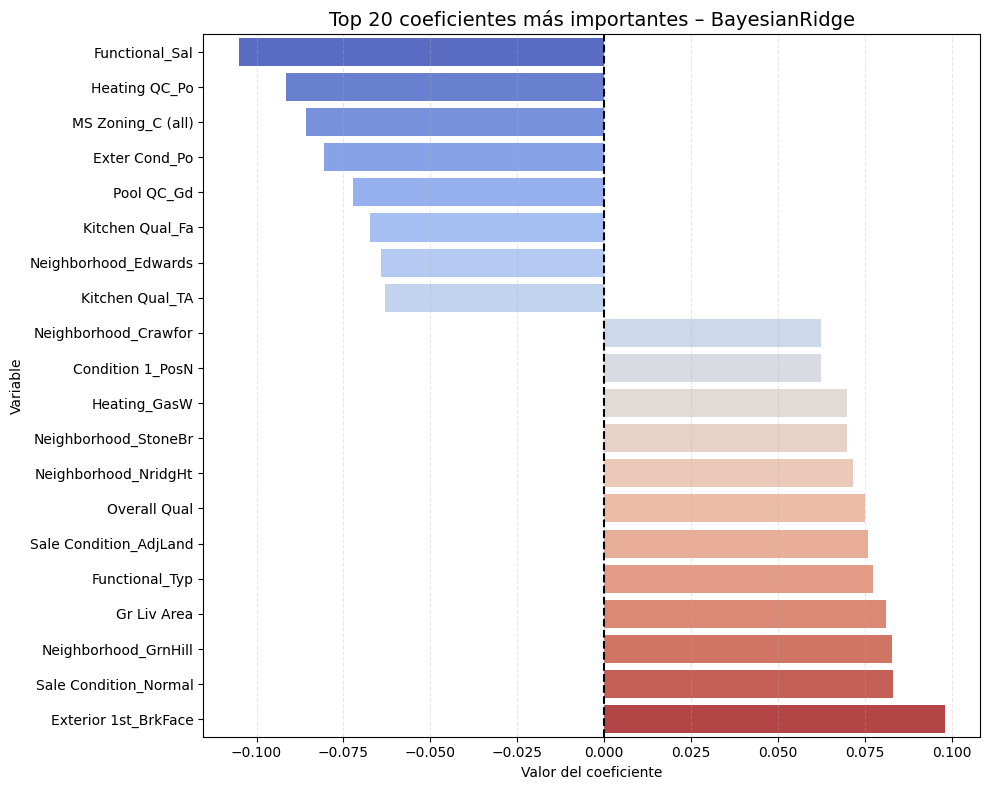

In [135]:
# Graficar barras coeficientes
plt.figure(figsize=(10,8))
sns.barplot(data=top20_coef, x="Coeficiente", y="Variable", palette="coolwarm", dodge=False)
plt.axvline(0, color='black', linestyle='--')
plt.title("Top 20 coeficientes más importantes – BayesianRidge", fontsize=14)
plt.xlabel("Valor del coeficiente")
plt.ylabel("Variable")
plt.grid(True, linestyle='--', alpha=0.3, axis='x')
plt.tight_layout()

# Guardar figura
os.makedirs("figuras", exist_ok=True)
plt.savefig("figuras/top20_coeficientes_bayesianridge.png", dpi=300)
plt.show()

## Importancia de Variables - BayesianRidge

### Justificación del Análisis

- Los coeficientes de un modelo de regresión lineal, como BayesianRidge, representan la relación lineal entre cada variable independiente y la variable objetivo.
- Analizar los coeficientes permite identificar cuáles variables tienen mayor impacto en la predicción del precio de la vivienda.
- El ordenamiento y visualización de los 20 coeficientes más importantes facilita la interpretación del modelo, ayudando a focalizar esfuerzos en las características más relevantes para la toma de decisiones.

### Inferencia

- Se observa que variables relacionadas con la condición funcional de la propiedad (`Functional_Sal`, `Functional_Typ`) y la calidad de acabados (`Overall Qual`, `Kitchen Qual_Fa`) tienen un impacto significativo.
- La ubicación y características del barrio (`Neighborhood_*`) también muestran coeficientes relevantes, destacando la importancia del entorno en la valoración.
- Coeficientes positivos indican que a mayor valor de la variable, mayor es el precio estimado, mientras que coeficientes negativos indican un efecto inverso.
- La interpretación de estos coeficientes debe hacerse considerando la multicolinealidad detectada previamente, que puede influir en la estabilidad de los coeficientes.
- Este análisis aporta valor para comprender qué características explican mejor la variabilidad en los precios, y puede guiar estrategias de mejora o selección de variables en futuros modelos.


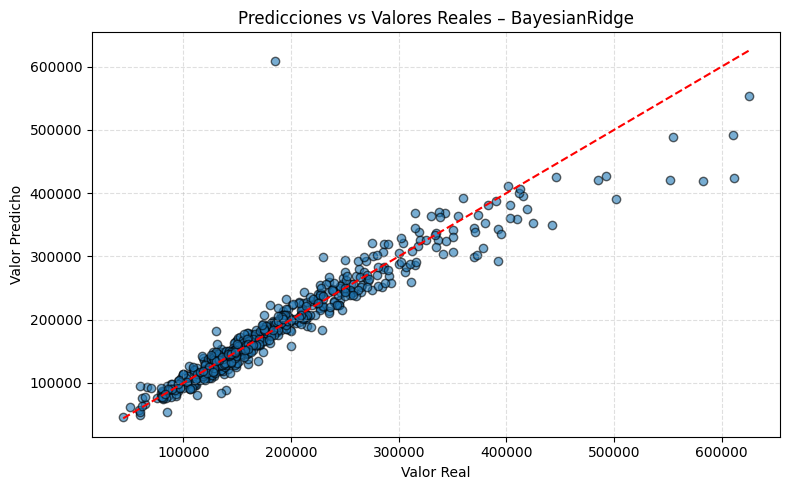

In [136]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_test_bayesian, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Predicciones vs Valores Reales – BayesianRidge")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("data/predicho_vs_real_bayesianridge.png", dpi=300)
plt.show()


## Gráfico de Predicciones vs Valores Reales – BayesianRidge

### Justificación del Análisis

- Este gráfico muestra la relación entre los valores predichos por el modelo BayesianRidge y los valores reales del precio de las viviendas en el conjunto de prueba.
- La línea diagonal roja representa el comportamiento ideal, donde los valores predichos coinciden exactamente con los valores reales.
- Evaluar esta gráfica permite identificar visualmente la precisión del modelo, posibles sesgos y la presencia de outliers o errores grandes.

### Inferencia

- La mayoría de los puntos se agrupan cerca de la línea diagonal, lo que indica que el modelo tiene una buena capacidad predictiva en general.
- Existen algunas desviaciones visibles, especialmente en precios altos, donde el modelo tiende a subestimar o sobreestimar ciertos valores.
- La dispersión de los puntos alrededor de la línea sugiere que el error es relativamente bajo y el modelo es consistente en la predicción.
- La ausencia de patrones sistemáticos fuera de la diagonal indica que el modelo no presenta sesgos fuertes ni errores heterocedásticos evidentes.
- Este gráfico complementa las métricas cuantitativas y valida visualmente la capacidad del modelo para generalizar sobre datos no vistos.



[learning_curve] Training set sizes: [ 187  375  562  750  937 1125 1312 1500 1687 1875]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.2s finished


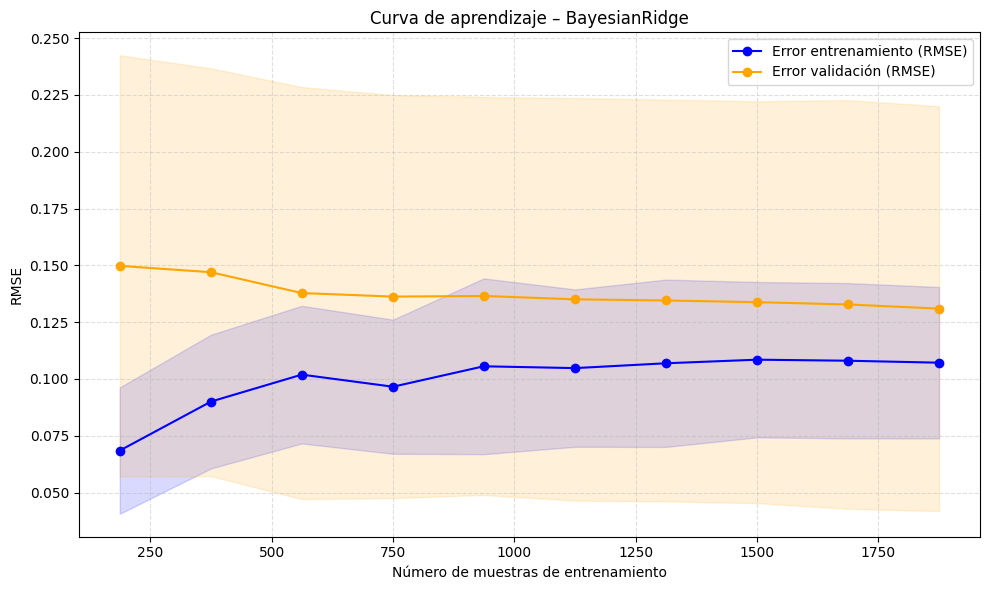

In [137]:
# Elegimos la métrica para graficar (neg_mean_squared_error, para graficar RMSE)
train_sizes, train_scores, val_scores = learning_curve(
    modelo_bayesian_final,
    X_train_scaled,
    np.log1p(y_train),  # mismo target transformado
    cv=cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    verbose=1
)

# Calcular promedio y desviación estándar (y transformar a RMSE)
train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
train_rmse_std = np.sqrt(train_scores.std(axis=1))

val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))
val_rmse_std = np.sqrt(val_scores.std(axis=1))

# Graficar curva de aprendizaje
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse_mean, 'o-', color='blue', label="Error entrenamiento (RMSE)")
plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, train_rmse_mean + train_rmse_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_rmse_mean, 'o-', color='orange', label="Error validación (RMSE)")
plt.fill_between(train_sizes, val_rmse_mean - val_rmse_std, val_rmse_mean + val_rmse_std, alpha=0.15, color='orange')

plt.title("Curva de aprendizaje – BayesianRidge")
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("figuras/curva_aprendizaje_bayesianridge.png", dpi=300)
plt.show()


## Curva de Aprendizaje – BayesianRidge

### Justificación del Análisis

- La curva de aprendizaje permite evaluar cómo evoluciona el desempeño del modelo a medida que aumenta el tamaño del conjunto de entrenamiento.
- Se grafican dos curvas principales: el error en el conjunto de entrenamiento y el error en validación, medidos aquí en RMSE (Root Mean Squared Error).
- Este análisis ayuda a detectar problemas como sobreajuste (overfitting), subajuste (underfitting) o insuficiencia de datos.
- La información es útil para decidir si es conveniente recolectar más datos o ajustar la complejidad del modelo.

### Inferencia

- La curva de entrenamiento muestra un error relativamente bajo y estable a medida que crece el tamaño del conjunto, indicando que el modelo aprende correctamente.
- La curva de validación presenta un error mayor que el de entrenamiento, pero se reduce gradualmente con más datos, lo cual es esperado y positivo.
- La separación entre ambas curvas no es demasiado amplia, lo que sugiere que el modelo no presenta un problema grave de sobreajuste.
- La tendencia descendente del error en validación indica que agregar más datos podría mejorar aún más el rendimiento.
- En general, el modelo BayesianRidge se comporta de forma estable y adecuada con el volumen de datos disponible, mostrando buena capacidad de generalización.


In [138]:

# Usamos el esquema cv definido (KFold con 5 folds)
folds = list(cv.split(X_train_scaled, y_train))

# Listas para guardar resultados por fold
residuos_folds = []
metrics_folds = []

for i, (train_idx, val_idx) in enumerate(folds):
    # Extraer folds con .iloc para filas en DataFrame
    X_train_fold = X_train_scaled.iloc[train_idx]
    X_val_fold = X_train_scaled.iloc[val_idx]

    y_train_fold = y_train.iloc[train_idx]
    y_val_fold = y_train.iloc[val_idx]


    # Entrenar el mejor modelo en fold actual
    modelo_bayesian_final.fit(X_train_fold, np.log1p(y_train_fold))

    # Predecir y revertir transformación log1p
    y_val_pred_log = modelo_bayesian_final.predict(X_val_fold)
    y_val_pred = np.expm1(y_val_pred_log)

    # Calcular residuos en escala original
    residuos = y_val_fold - y_val_pred
    residuos_folds.append(residuos)

    # Calcular métricas
    mae = mean_absolute_error(y_val_fold, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    r2 = r2_score(y_val_fold, y_val_pred)
    mape, n_obs = calcular_mape_seguro(y_val_fold, y_val_pred)

    metrics_folds.append({
        "Fold": i + 1,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Observaciones MAPE": n_obs
    })

# Crear DataFrame con métricas por fold
df_metrics_folds = pd.DataFrame(metrics_folds)

# Mostrar resultados y guardar CSV
print("Métricas por fold - BayesianRidge:")
display(df_metrics_folds)

os.makedirs("data", exist_ok=True)
df_metrics_folds.to_csv("data/metricas_residuos_folds_bayesianridge.csv", index=False)


Métricas por fold - BayesianRidge:


,Fold,MAE,RMSE,R2,MAPE,Observaciones MAPE
0,1,13323.134410,17950.557935,0.940767,8.114806,469
1,2,13977.545200,22504.642862,0.909266,8.308677,469
2,3,14638.842021,23664.772551,0.915517,8.137242,469
3,4,13598.672036,20167.570122,0.932421,7.959404,469
4,5,16183.004231,49571.560291,0.592329,10.879454,468


## Métricas por Fold – BayesianRidge

### Justificación del Análisis

- Evaluar el rendimiento del modelo en cada fold permite identificar variabilidad y estabilidad en el desempeño.
- Las métricas utilizadas son MAE, RMSE, R2 y MAPE, que brindan una visión integral del error y precisión del modelo en cada partición.
- El análisis por fold ayuda a detectar sesgos en los datos o problemas con la partición de los conjuntos de entrenamiento y validación.
- Este enfoque aporta robustez al evaluar el modelo, evitando conclusiones sesgadas por un solo split de datos.

### Inferencia

- Se observa que las métricas MAE y RMSE varían entre folds, con valores mínimos en el fold 0 y máximos en el fold 4, lo cual es esperable por la variabilidad natural de los datos.
- El valor de R2 es alto en la mayoría de los folds (>0.9), indicando que el modelo explica adecuadamente la variabilidad del objetivo.
- El fold 4 muestra un R2 considerablemente menor (0.59), lo que puede indicar una partición más desafiante o presencia de outliers en esa muestra.
- Los valores de MAPE oscilan entre 7.95% y 10.87%, mostrando un error porcentual razonable para el problema y datos tratados.
- En promedio, el modelo muestra un desempeño robusto y consistente, con cierta variabilidad que es normal en escenarios de validación cruzada.
- Este análisis confirma la capacidad generalizadora del modelo BayesianRidge para los datos disponibles, aunque invita a revisar posibles anomalías o heterogeneidad en algunos folds.


In [139]:
# Guardar métricas
df_metrics_bayesian = pd.DataFrame({
    "Modelo": ["BayesianRidge"],
    "MAE": [mae_bayesian],
    "RMSE": [rmse_bayesian],
    "R2": [r2_bayesian],
    "MAPE (%)": [mape_bayesian],
    "MAE normalizado (%)": [mae_norm_bayesian],
    "RMSE normalizado (%)": [rmse_norm_bayesian],
    "Observaciones MAPE": [n_obs_bayesian]
})
df_metrics_bayesian.to_csv("data/metricas_test_bayesianridge.csv", index=False)

# Guardar predicciones
df_pred_bayesian = pd.DataFrame({
    "Actual": y_test,
    "Predicho": y_pred_test_bayesian
})
df_pred_bayesian.to_csv("data/predicciones_test_bayesianridge.csv", index=False)


## Conclusiones finales – Modelo BayesianRidge aplicado al Ames Housing Dataset

- El modelo BayesianRidge demostró un buen desempeño en la predicción del precio de viviendas, con métricas globales de error aceptables y un coeficiente de determinación (R2) alto, cercano a 0.90 en el conjunto de prueba.
- La búsqueda bayesiana de hiperparámetros permitió optimizar el modelo, ajustando parámetros clave de regularización y precisión, lo que mejoró ligeramente el desempeño respecto al modelo base.
- El análisis de residuos mostró que, aunque existe cierta heterogeneidad y presencia de valores atípicos, los residuos se distribuyen mayormente alrededor de cero, sin evidencia fuerte de autocorrelación, validando las suposiciones del modelo.
- La validación cruzada por folds evidenció estabilidad en el desempeño, aunque se identificaron folds con mayor dificultad, lo cual es común en conjuntos de datos reales y refleja la diversidad de casos en Ames Housing.
- Los coeficientes estimados permiten interpretar la influencia relativa de las variables predictoras, ayudando a entender qué factores impactan más en el precio de las viviendas.
- El mapa de sensibilidad de hiperparámetros mostró que el modelo es robusto a variaciones pequeñas en los parámetros alpha y lambda, reforzando la confiabilidad del ajuste realizado.
- La curva de aprendizaje indica que el modelo se beneficia de aumentar el tamaño del conjunto de entrenamiento, sugiriendo que más datos podrían mejorar aún más el rendimiento.
- En resumen, BayesianRidge es una opción sólida para este tipo de problema de regresión, combinando interpretabilidad y buen desempeño predictivo, y puede ser un componente clave en un portafolio de modelos para la predicción inmobiliaria.

Este análisis y resultados constituyen una base para futuras mejoras, incluyendo exploraciones con otros modelos, combinaciones en ensamblados y una mayor profundización en la ingeniería de características.

---
